In [5]:
# import libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [6]:
df = pd.read_excel("../data/SWaT_Dataset_Attack_v0.xlsx")

df.columns = [
	'TIMESTAMP','FIT101','LIT101','MV101','P101','P102','AIT201','AIT202','AIT203','FIT201','MV201','P201','P202','P203',
    'P204','P205','P206','DPIT301','FIT301','LIT301','MV301','MV302','MV303','MV304','P301','P302','AIT401','AIT402','FIT401',
    'LIT401','P401','P402','P403','P404','UV401','AIT501','AIT502','AIT503','AIT504','FIT501','FIT502','FIT503','FIT504',
    'P501','P502','PIT501','PIT502','PIT503','FIT601','P601','P602','P603','OUTCOME'
]

# The first row only contains labels
# 'TIMESTAMP' is irrelevant for the thesis
# The other dropped columns contain either only 0s, only 1s or only 2s and are therefore irrelevant

df = df.iloc[1:]
df = df.drop(['TIMESTAMP', 'P202', 'P301', 'P401', 'P404', 'P502', 'P601', 'P603'], axis = 1)

# The dataset labels attacks by 'A ttack' and 'Attack', and labels normal data as 'Normal'
# To keep the same structure in all datasets, the 'A ttack' and 'Attack' values are changed to '-1' and normal values to '1'

df['OUTCOME'].replace(to_replace = ['A ttack', 'Attack'], value = 1, inplace = True)
df['OUTCOME'].replace(to_replace = ['Normal'], value = 0, inplace = True)

# data types need to be numeric to be encoded to z-scores --> convert column object data types to numerics

cols = df.columns[df.columns != 'OUTCOME']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Encoding the feature vectors to z-scores

cols = list(df.columns[df.columns != 'OUTCOME'])
for col in cols:
    df[col] = ((df[col] - df[col].mean())/df[col].std(ddof=0))

c:\Users\berry\miniconda3\envs\quantum_senese\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\berry\AppData\Local\Temp\ipykernel_1226964\2368209640.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['OUTCOME'].replace(to_replace = ['A ttack', 'Attack'], value = 1, inplace = True)
C:\Users\berry\AppData\Local\Temp\ipykernel_1226964\2368209640.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed

In [7]:
# Creating normal and attack masks
normal_mask = df[df.OUTCOME == 0]
attack_mask = df[df.OUTCOME == 1]

In [8]:
# Creating X_training and X_testing datasets
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 42)

X_train = X_train[X_train.OUTCOME == 0]
X_train = X_train.drop(['OUTCOME'], axis=1)

y_test = X_test['OUTCOME']
X_test = X_test.drop(['OUTCOME'], axis=1)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(316353, 44)
(89984, 44)
(89984,)


In [9]:
# Building the autoencoder model and showing its summary
ae = model = Sequential()
model.add(Dense(35, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(X_train.shape[1]))

ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 35)                1575      
                                                                 
 dense_1 (Dense)             (None, 30)                1080      
                                                                 
 dense_2 (Dense)             (None, 25)                775       
                                                                 
 dense_3 (Dense)             (None, 30)                780       
                                                                 
 dense_4 (Dense)             (None, 35)                1085      
                                                                 
 dense_5 (Dense)             (None, 44)                1584      
                                                                 
Total params: 6879 (26.87 KB)
Trainable params: 6879 (26

In [15]:
# Train the model
nb_epoch = 50
batch_size = 64

ae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="./model.SWAT.keras", verbose=0)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = ae.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                 validation_data=(X_test, X_test), verbose=1, callbacks=[checkpointer, tensorboard]).history

Epoch 1/50
4944/4944 [==============================] - 11s 2ms/step - loss: 0.0065 - accuracy: 0.9248 - val_loss: 0.1534 - val_accuracy: 0.8734
Epoch 2/50
4944/4944 [==============================] - 9s 2ms/step - loss: 0.0058 - accuracy: 0.9284 - val_loss: 0.1583 - val_accuracy: 0.7855
Epoch 3/50
4944/4944 [==============================] - 9s 2ms/step - loss: 0.0050 - accuracy: 0.9287 - val_loss: 0.1429 - val_accuracy: 0.8797
Epoch 4/50
4944/4944 [==============================] - 9s 2ms/step - loss: 0.0049 - accuracy: 0.9300 - val_loss: 0.1630 - val_accuracy: 0.8627
Epoch 5/50
4944/4944 [==============================] - 9s 2ms/step - loss: 0.0044 - accuracy: 0.9343 - val_loss: 0.1788 - val_accuracy: 0.8647
Epoch 6/50
4944/4944 [==============================] - 10s 2ms/step - loss: 0.0046 - accuracy: 0.9349 - val_loss: 0.2160 - val_accuracy: 0.8787
Epoch 7/50
4944/4944 [==============================] - 10s 2ms/step - loss: 0.0041 - accuracy: 0.9386 - val_loss: 0.2064 - val_accura

In [16]:
# Save the model 
ae = load_model('model.SWAT.keras')

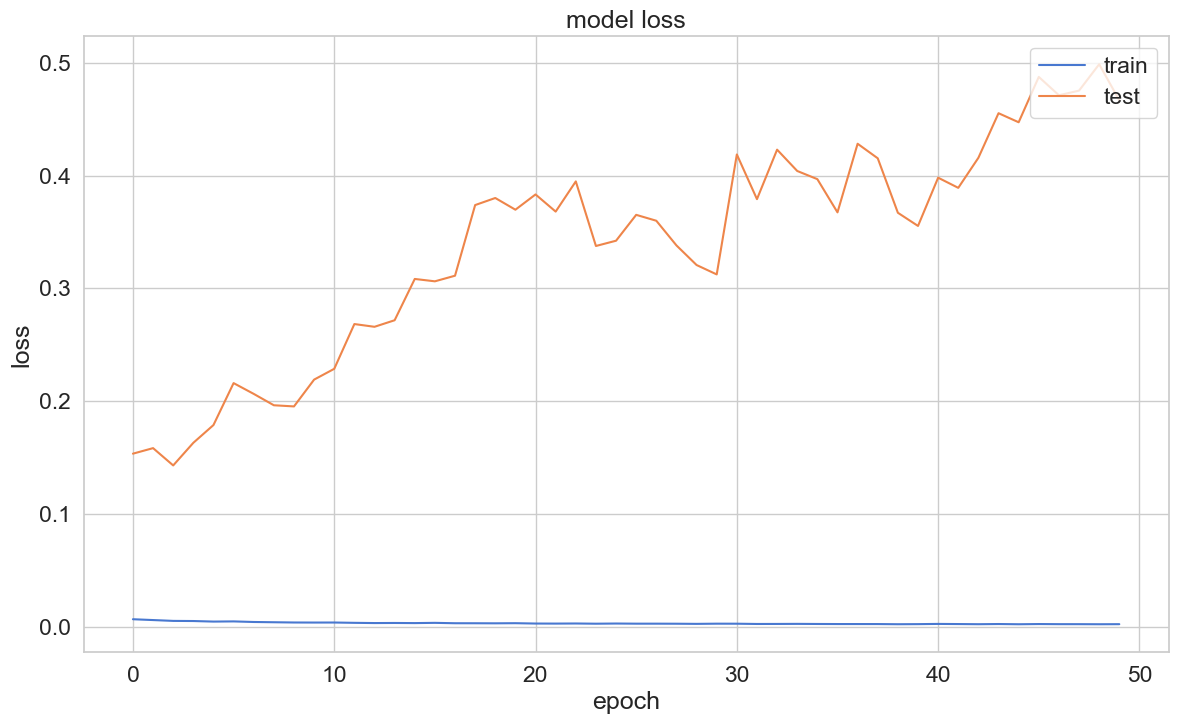

In [17]:
# Plot model loss over the amount of epochs
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
# plt.savefig('loss_SWAT_GoodModel.png')

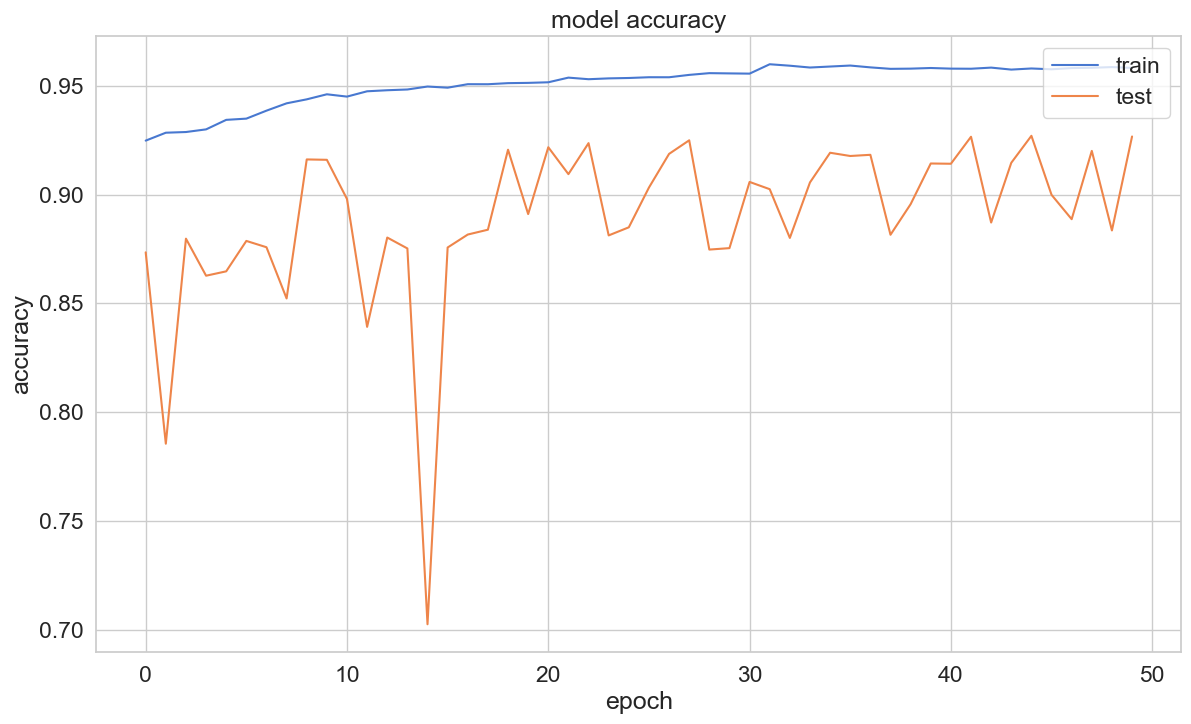

In [18]:
# Plotting model accuracy over the amount of epochs
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
# plt.savefig('accuracy_SWaT_GoodModel.png')

In [19]:
# Calculating the predictions of the autoencoder model on X_test testing sample
predictions = ae.predict(X_test)

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000012D78FDDAB0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000012D78FDDAB0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Orig

In [20]:
# Calculating MSE and reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [21]:
error_df.describe()

,reconstruction_error,true_class
count,89984.000000,89984.000000
mean,0.466802,0.122677
std,42.853532,0.328068
min,0.000028,0.000000
25%,0.000207,0.000000
50%,0.000356,0.000000
75%,0.000792,0.000000
max,4521.652970,1.000000


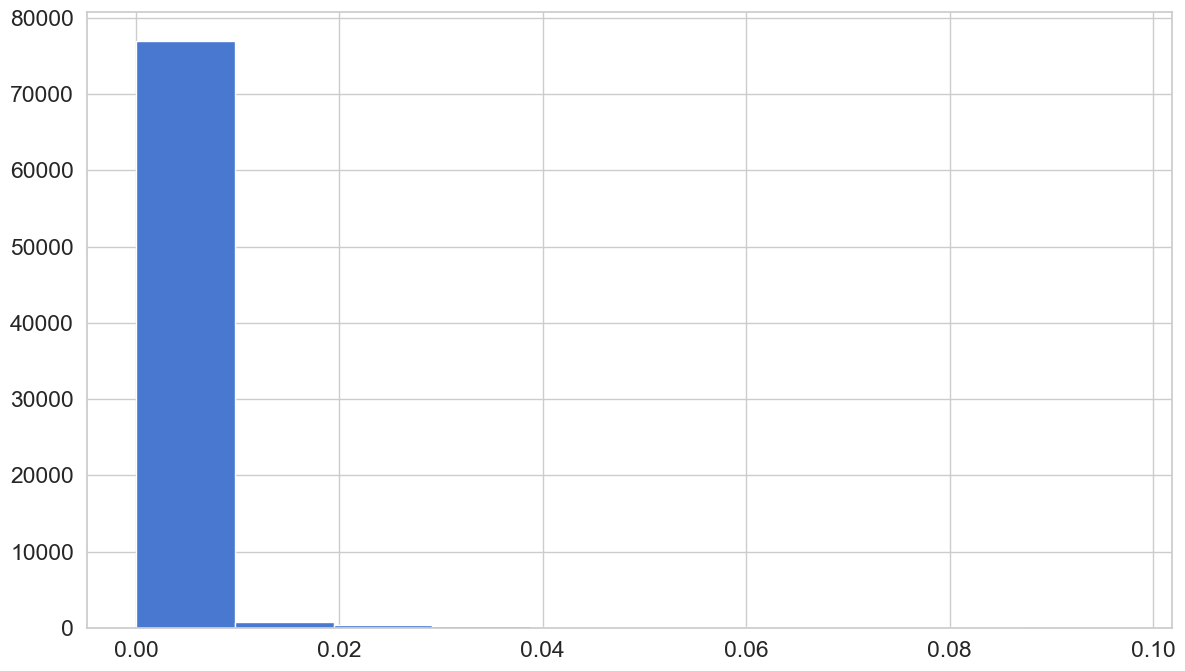

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class'] == 0) & (error_df['reconstruction_error'] < 0.1)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

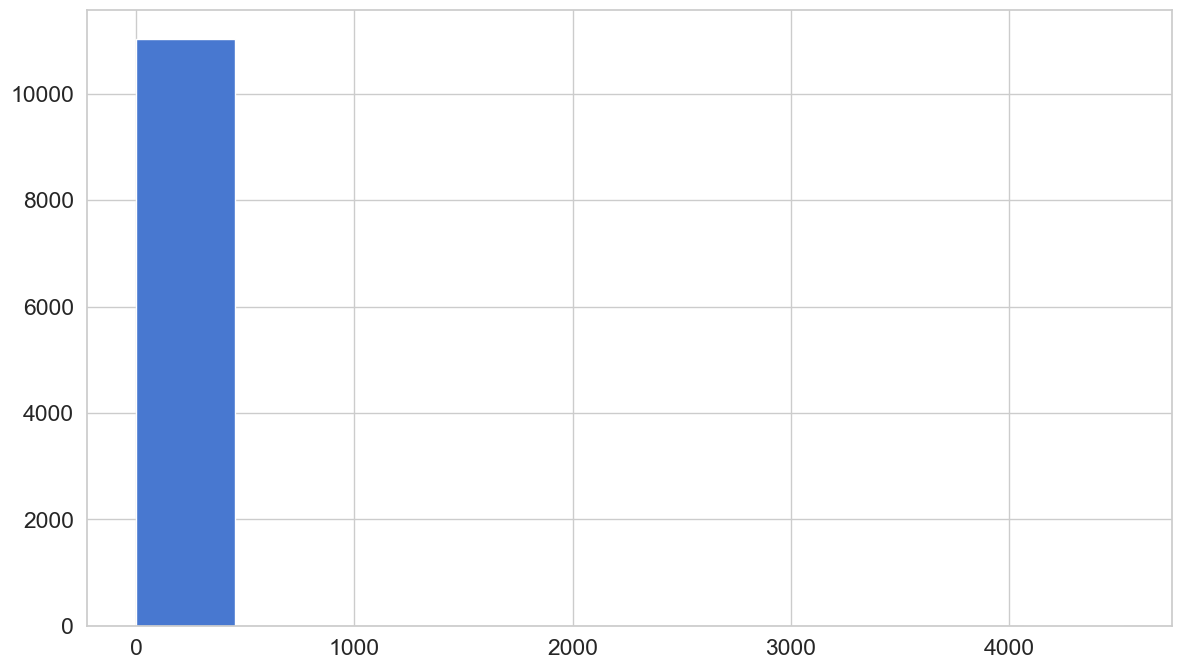

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [24]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

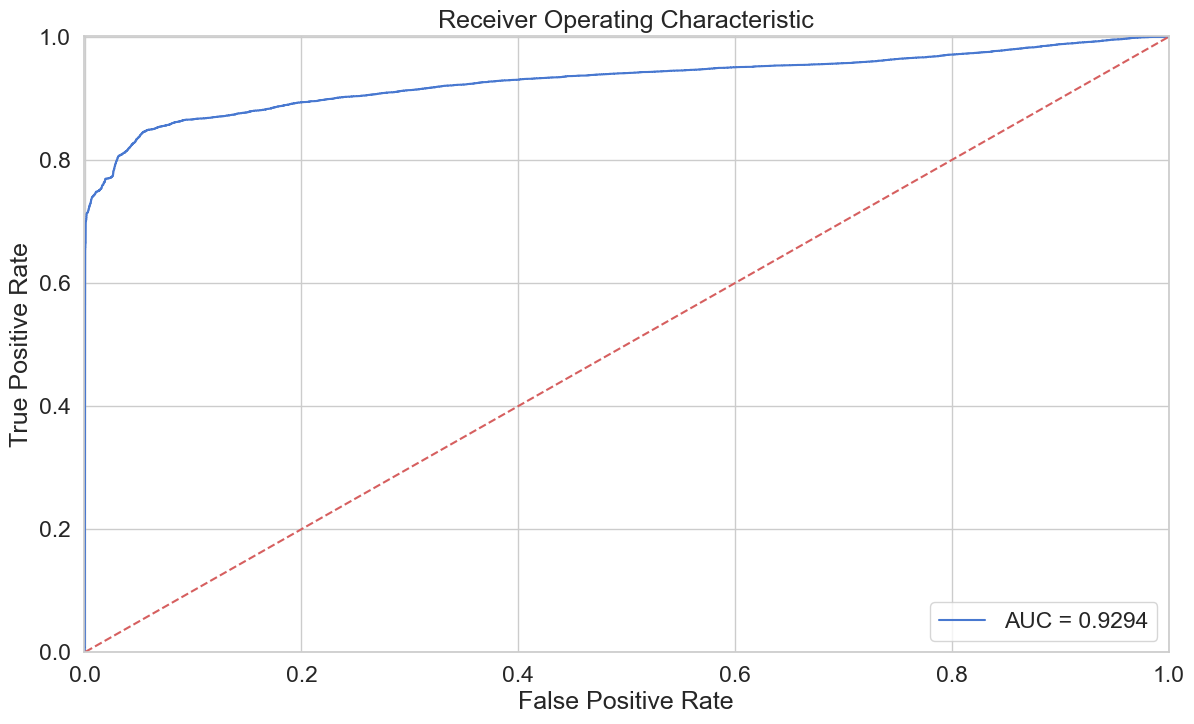

In [25]:
# Calculating and plotting the ROC curve
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([-1,1],[-1,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.savefig('ROC_SWAT2.png')
plt.show();

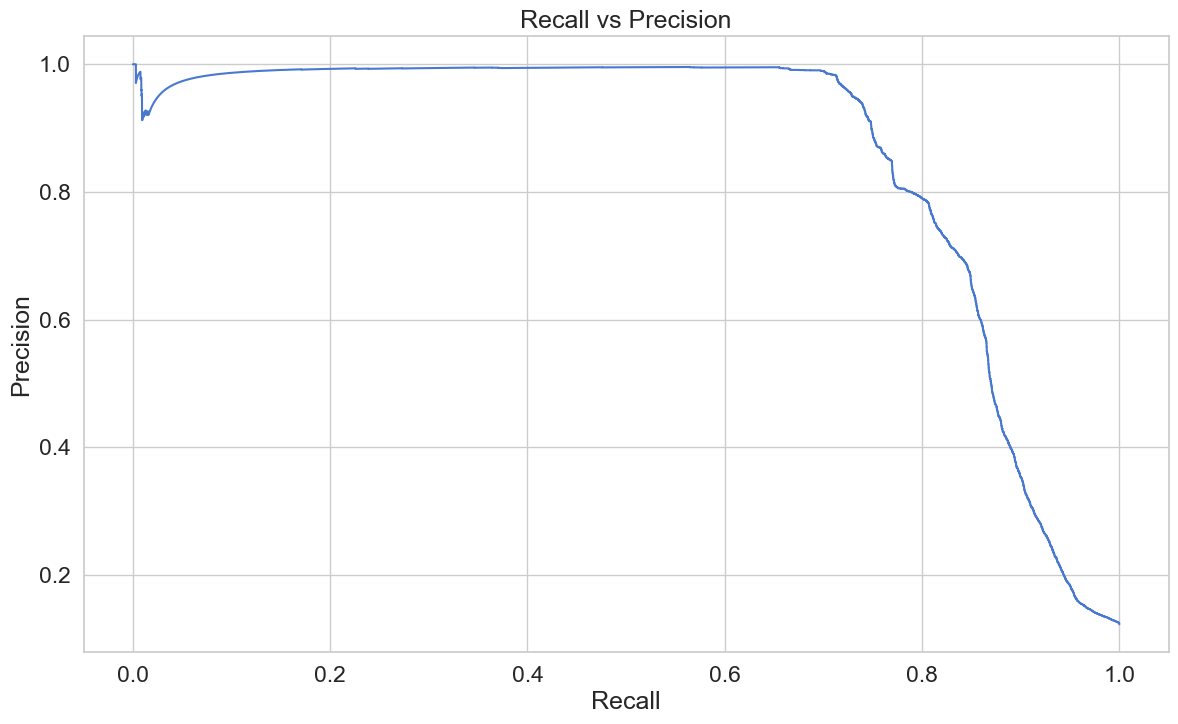

In [26]:
# Plotting Recall vs Precision plot
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
# high precision = low false positive
# high recall = low false negative 

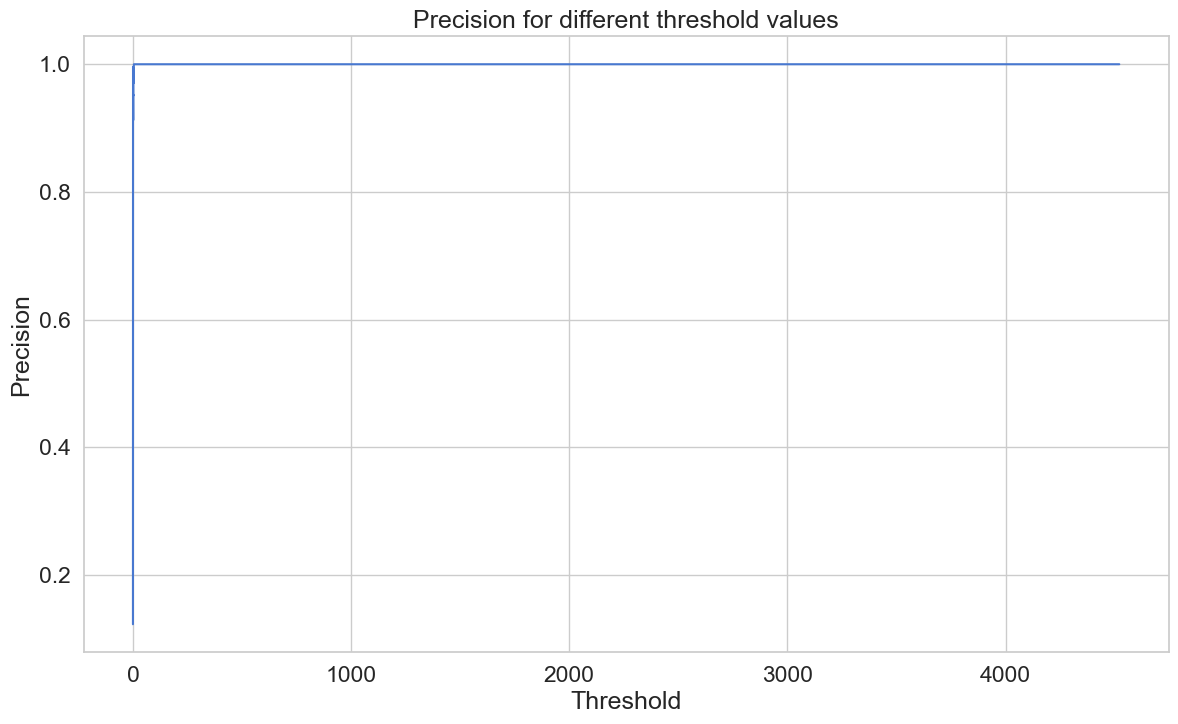

In [27]:
# Plotting precision metrics for different threshold values to find optimal threshold
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
# plt.savefig('precision_threshold_SWAT.png')
plt.show()

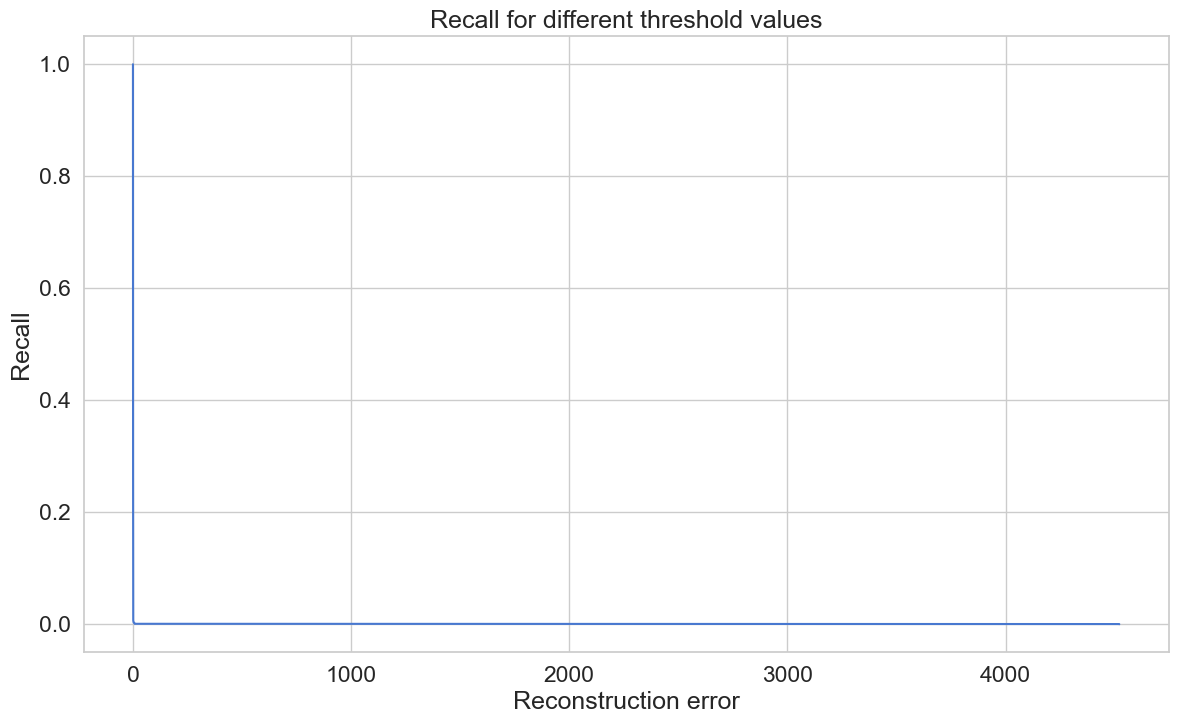

In [28]:
# Plotting recall metrics for different threshold values to find optimal threshold
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [29]:
# Setting the manual threshold
threshold = 0.03

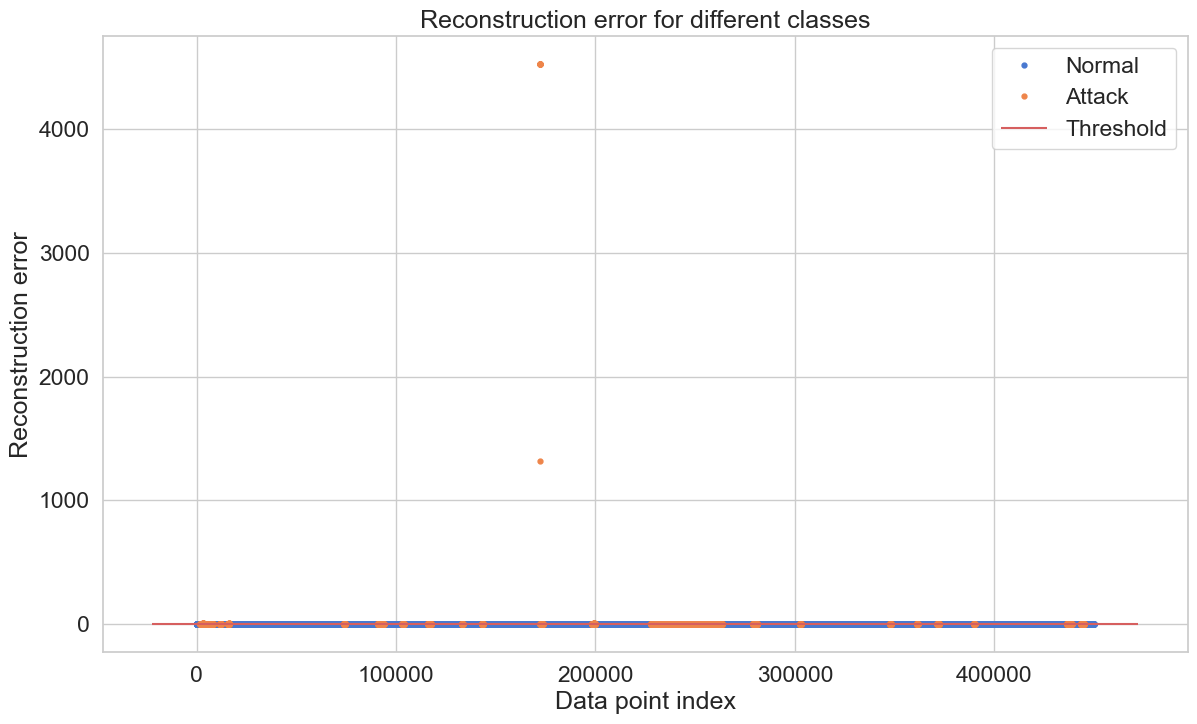

In [30]:
# Plot reconstruction error per datapoint index for the manually defined threshold
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
# plt.savefig('Threshold SWaT.png')

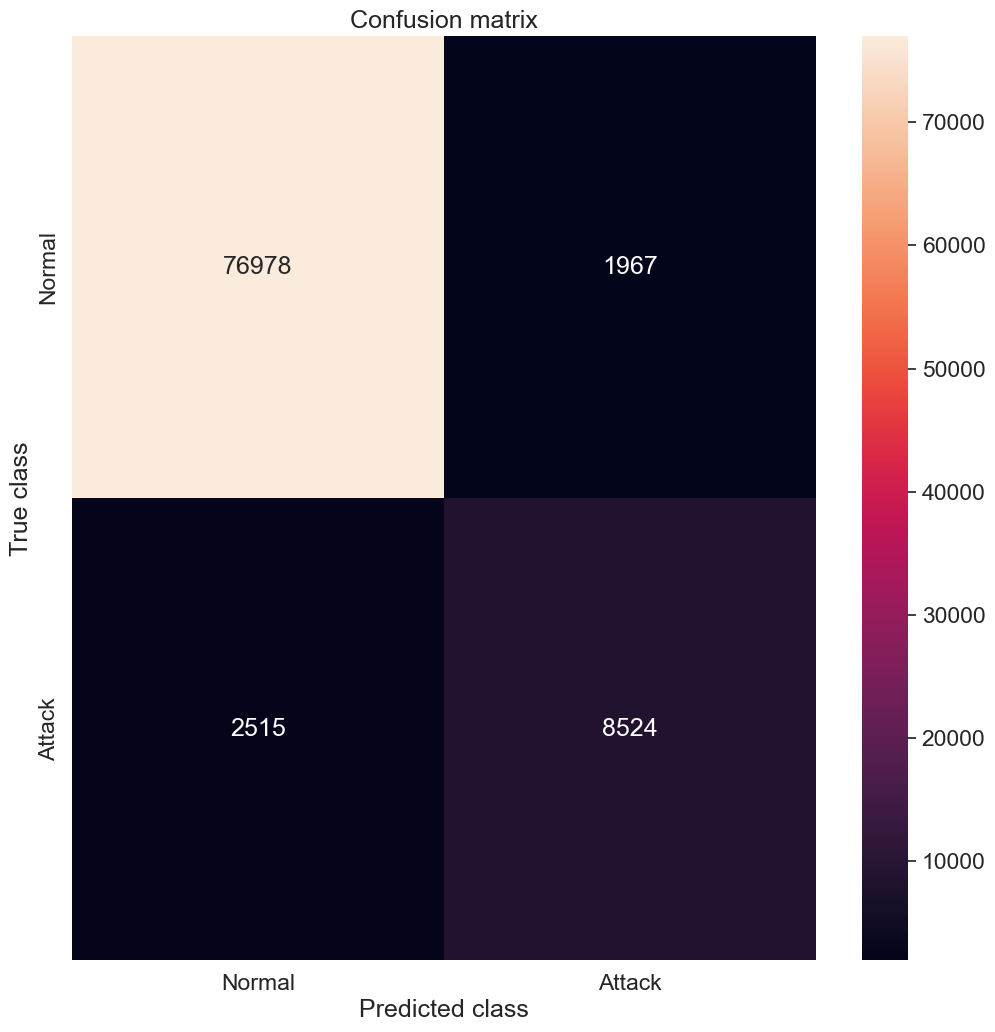

In [31]:
# Plotting the confusion matrix
threshold = 0.01
LABELS = ["Normal", "Attack"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()